## Further Analysis

In this notebook, we apply some machine learning algorithms check for feature importances and test out hypotheses from the earlier data exploration. Concluding remarks are given below and at the end of the notebook.

## Concluding Remarks

Both models indicate that having a name and being spayed/neutered are the most important features in determining the outcome of the animal. This is not surprising: a majority of the animals in the dataset end up adopted, and animal shelters tend to name and spay/neuter the animal before putting it up for adoption. <br><br>

Both models also indicate that the age range of the animal has a significant impact on the outcome of the animal. It's widely known that younger dogs have a greater chance of being adopted than older dogs, so it's not surprising that the models picked up on this. <br><br>

The XGBoost model noticed that pit bulls had significantly different outcomes compared to other breeds. <br><br>

The models we produced would not be good predictors in determining the outcome of an animals based on the characteristics we've analyzed. This is partially due to the following: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1) There is significantly more adoption outcomes than any other outcomes, and <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2) It could be that the characteristics we've analyzed do not separate the classes well enough. <br> <br>

More characteristics about the animal and circumstances surrounding the intake of the animal may also help to improve our model: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1) The day and time the animal is processed into the shelter would be helpful. This information, along with the date of birth of the animal, would better describe the age range of the animal, which already seems to have a significant impact in determining the outcome of the animal. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2) Other characteristics such as behavior and health affect the adoption/intake process and may help better train the models to predict death and adoption.

In [1]:
#Import relevant packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix
%matplotlib inline

#Constants unsed in the notebook.
test_size = 0.2
random_state = 42

#Set graphics styles.
sns.set(style = 'whitegrid', context = 'notebook', palette = 'deep')

In [2]:
#Import the data.
dataset = pd.read_csv(r"C:\Users\Patrick\Desktop\ShelterOutcomes2\Austin_Animal_Center_Outcomes_FE.csv")

### Data Preparation

In this section, we prepare our data to bed fed into our machine learning algorithms.

In [3]:
dataset.head(10)

,Animal ID,Outcome Type,Breed,Color,Altered,Sex,HasName,AgeRange,MixedBreed,MixedColor,StrayHold
0,A771830,Adoption,Pit Bull,White,Altered,Male,1,Young,1,1,1
1,A658751,Return to Owner,Rare,Tan,Altered,Male,1,Adult,1,0,0
2,A746650,Return to Owner,Labrador Retriever,Rare,Intact,Female,1,Young,1,0,0
3,A750122,Transfer,Labrador Retriever,Black,Intact,Male,1,Young,1,0,0
4,A784168,Transfer,Rare,Black,Intact,Male,0,Young,1,1,0
5,A666430,Transfer,Rare,White,Altered,Female,1,Adult,1,1,0
6,A675708,Adoption,Pit Bull,Blue,Altered,Male,1,Adult,0,1,1
7,A680386,Transfer,Rare,White,Altered,Male,1,Senior,1,0,0
8,A664462,Transfer,Rare,Brown,Intact,Male,1,Adult,1,1,1
9,A762837,Transfer,Rare,Rare,Altered,Male,0,Young,1,1,0


In [4]:
print('There are ' + str(dataset.shape[0]) + ' observations and ' + str(dataset.shape[1]) + ' fields.')

There are 54147 observations and 11 fields.


In [5]:
dataset.dtypes

Animal ID       object
Outcome Type    object
Breed           object
Color           object
Altered         object
Sex             object
HasName          int64
AgeRange        object
MixedBreed       int64
MixedColor       int64
StrayHold        int64
dtype: object

In [6]:
dataset.describe()

,HasName,MixedBreed,MixedColor,StrayHold
count,54147.000000,54147.000000,54147.000000,54147.000000
mean,0.836076,0.930689,0.659242,0.203594
std,0.370210,0.253985,0.473968,0.402674
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [7]:
def one_hot_encode(source_data, attrs):
    """
    One-hot encodes the field and deletes the original field.
    """
    for attr in attrs:
        one_hot = pd.get_dummies(source_data[attr], prefix = attr)
        source_data.drop([attr], axis = 1, inplace = True)
        source_data = source_data.join(one_hot, lsuffix = attr)
    return source_data

In [9]:
encode_cols = ['Breed', 'Color', 'Altered', 'Sex', 'AgeRange']
dataset = one_hot_encode(dataset, encode_cols)
dataset.head(10)

,Animal ID,Outcome Type,HasName,MixedBreed,MixedColor,StrayHold,Breed__Australian Cattle Dog,Breed__Chihuahua Shorthair,Breed__German Shepherd,Breed__Labrador Retriever,...,Color__White,Altered__Altered,Altered__Intact,Altered__Unknown,Sex__Female,Sex__Male,Sex__Unknown,AgeRange__Adult,AgeRange__Senior,AgeRange__Young
0,A771830,Adoption,1,1,1,1,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
1,A658751,Return to Owner,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,A746650,Return to Owner,1,1,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
3,A750122,Transfer,1,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,1
4,A784168,Transfer,0,1,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
5,A666430,Transfer,1,1,1,0,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0
6,A675708,Adoption,1,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
7,A680386,Transfer,1,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
8,A664462,Transfer,1,1,1,1,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
9,A762837,Transfer,0,1,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


### Random Forest and XGBoost

We'll run a random forest and XGBoost on our dataset. (Note: the parameters for each model were chosen by testing a few values. In the future, I plan to fine tune the parameters use GridSearch_CV).

In [10]:
#Split the data into test and train data.
train, test = train_test_split(dataset, test_size = test_size, random_state = random_state)
X_train = train.copy()
X_train.drop(['Outcome Type', 'Animal ID'], axis = 1, inplace = True)
X_test = test.copy()
X_test.drop(['Outcome Type', 'Animal ID'], axis = 1, inplace = True)
y_train = train['Outcome Type']
y_test = test['Outcome Type']

In [25]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Initialize our models.
rf = RandomForestClassifier(n_estimators = 500
                           , max_features = 'sqrt'
                           , criterion = 'gini'
                           , random_state = random_state)

xgb_model = xgb.XGBClassifier(objective = 'multi:softprob'
                              , random_state = 42
                              , learning_Rate = 0.01
                              , colsample_bytree = 0.8
                              , subsample = 0.8
                              , n_estimators = 1000
                              , reg_alpha = 0.3
                              , max_depth = 6
                              , gamma = 10)

#Fit the models to the training data.
rf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

#Get model probabilities.
y_prob_rf = rf.predict_proba(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

#Get model predictions.
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

#Get the order of the outcome types.
classes = rf.classes_

In [26]:
#To check model accuracy, calculate the log loss score.
print('The log loss score for random forest is ' + str(round(log_loss(y_test, y_prob_rf, eps = 1e-15), 2)) + 
      ' and the log loss score for XGBoost is ' + str(round(log_loss(y_test, y_prob_xgb, eps = 1e-15), 2)))

The log loss score for random forest is 1.44 and the log loss score for XGBoost is 0.88


Our XGBoost model seems to outperform the random forest model. Let's see how each model ranks feature importances.

In [27]:
#Get feature importances for each model.
feature_importances_rf = pd.DataFrame(rf.feature_importances_
                                   , index = X_train.columns
                                   , columns = ['Importance']).sort_values('Importance'
                                                                           , ascending = True)
feature_importances_xgb = pd.DataFrame(xgb_model.feature_importances_
                                   , index = X_train.columns
                                   , columns = ['Importance']).sort_values('Importance'
                                                                           , ascending = True)

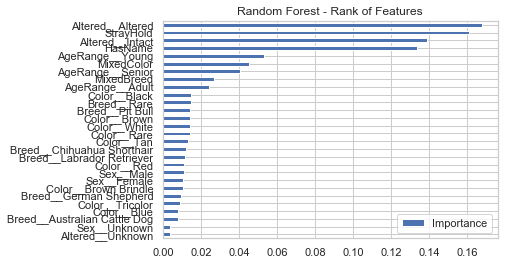

In [28]:
#Plot feature improtances for the Random Forest model.
feature_importances_rf.plot(kind = 'barh', title = 'Random Forest - Rank of Features')

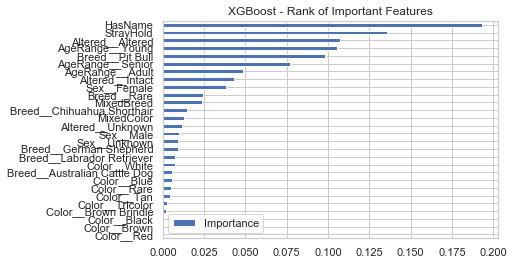

In [29]:
#Plot feature importances for the XGBoost model.
feature_importances_xgb.plot(kind = 'barh', title = 'XGBoost - Rank of Important Features')

Random Forest ranks alter status, being part of the stray hold program, and having a name as the most important features.

XGBoost ranks having a name, being part of the stray hold program, the alter status, age range, and being a pit bull as the most important features.

In [30]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [31]:
#Get confusion matrices for our models.
cm_rf = confusion_matrix(y_true = y_test, y_pred = y_pred_rf, labels = classes)
cm_xgb = confusion_matrix(y_true = y_test, y_pred = y_pred_xgb, labels = classes)

Confusion matrix, without normalization
[[4052    7  781  113]
 [ 116   23  143   95]
 [1186   12 1824  143]
 [ 939   37  507  852]]


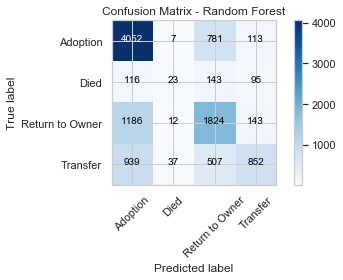

In [32]:
#Plot the confusion matrix for the random forest model.
plot_confusion_matrix(cm_rf
                     , classes = classes
                     , normalize = False
                     , title = 'Confusion Matrix - Random Forest')

Confusion matrix, without normalization
[[4266    0  656   31]
 [ 120    5  144  108]
 [1303    0 1794   68]
 [ 996    3  535  801]]


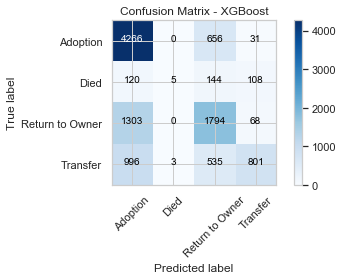

In [33]:
#Plot the confusion matrix for the XGBoost model.
plot_confusion_matrix(cm_xgb
                     , classes = classes
                     , normalize = False
                     , title = 'Confusion Matrix - XGBoost')

In [103]:
def get_recall_precision(cm):
    """
    Given a confusion matrix, compute the precision and recall scores. Returns a matrix summarizing the results.
    """
    true_pos = np.diag(cm)
    false_pos = np.sum(cm, axis=0) - true_pos
    false_neg = np.sum(cm, axis=1) - true_pos

    precision = np.transpose(true_pos / (true_pos + false_pos))
    recall = np.transpose(true_pos / (true_pos + false_neg))
    
    precision = np.around(precision, 2)
    recall = np.around(recall, 2)
    
    summary = pd.DataFrame(np.stack((recall, precision)), index = ['Recall', 'Precision'])
    return summary

In [104]:
#Compute recall and precision for our models.
rp_rf = get_recall_precision(cm_rf)
rp_rf.columns = classes
rp_xgb = get_recall_precision(cm_xgb)
rp_xgb.columns = classes

In [105]:
#Get recall and precision matrix for the random forest model.
rp_rf

,Adoption,Died,Return to Owner,Transfer
Recall,0.82,0.06,0.58,0.36
Precision,0.64,0.29,0.56,0.71


In [106]:
#Get recall and precision matrix for the XGBoost model.
rp_xgb

,Adoption,Died,Return to Owner,Transfer
Recall,0.86,0.01,0.57,0.34
Precision,0.64,0.62,0.57,0.79


The XGBoost model does a better job at predicting whether an animal will be adopted; however, the random forest model does slightly better identifying everything else. The XGBoost model is overall more precise than the random forest model.

## Concluding Remarks

Both models indicate that having a name and being spayed/neutered are the most important features in determining the outcome of the animal. This is not surprising: a majority of the animals in the dataset end up adopted, and animal shelters tend to name and spay/neuter the animal before putting it up for adoption. <br><br>

Both models also indicate that the age range of the animal has a significant impact on the outcome of the animal. It's widely known that younger dogs have a greater chance of being adopted than older dogs, so it's not surprising that the models picked up on this. <br><br>

The XGBoost model noticed that pit bulls had significantly different outcomes compared to other breeds. <br><br>

The models we produced would not be good predictors in determining the outcome of an animals based on the characteristics we've analyzed. This is partially due to the following: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1) There is significantly more adoption outcomes than any other outcomes, and <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2) It could be that the characteristics we've analyzed do not separate the classes well enough. <br> <br>

More characteristics about the animal and circumstances surrounding the intake of the animal may also help to improve our model: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1) The day and time the animal is processed into the shelter would be helpful. This information, along with the date of birth of the animal, would better describe the age range of the animal, which already seems to have a significant impact in determining the outcome of the animal. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2) Other characteristics such as behavior and health affect the adoption/intake process and may help better train the models to predict death and adoption.